# LightGlue Demo

This notebook demonstrates how you can install and use LightGlue, a 2023 library for feature point matching. Check their GitHub page for more details and a link to the paper: https://github.com/cvg/LightGlue

This Demo uses the SuperPoint detector from the paper that you read for your Assessment 1. LightGlue also comes with an implementation of DISK, another learned detector. You can use LightGlue with other descriptors too, e.g. SIFT.

Besides using LightGlue, this notebook also demonstrates how you can quite easily install and use any other library that is available via pip / git on the Jupyter server.

### Install LightGlue

In [1]:
# this clones the repo and installs the dependencies
from pathlib import Path
if Path.cwd().name != 'LightGlue':
  !git clone --quiet https://github.com/cvg/LightGlue/
  %cd LightGlue
  !pip install --progress-bar off --quiet -e .
    
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
torch.set_grad_enabled(False);
images = Path('assets')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 'mps', 'cpu'

%cd ..

/home/castrou/university/enn583/Week 2/LightGlue
/home/castrou/university/enn583/Week 2


### Get Access to the Kitti Dataset

In [2]:
import torchvision
import pykitti

basedir = '../kitti'
date = '2011_09_26'
drive = '0035'

# The 'frames' argument is optional - default: None, which loads the whole dataset.
# Calibration, timestamps, and IMU data are read automatically. 
# Camera and velodyne data are available via properties that create generators
# when accessed, or through getter methods that provide random access.
# data = pykitti.raw(basedir, date, drive, frames=range(0, 50, 5))
data = pykitti.raw(basedir, date, drive)

### Extract SuperPoints and use LightGlue to match them

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /home/castrou/.cache/torch/hub/checkpoints/superpoint_v1.pth
100.0%
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /home/castrou/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv-pth
100.0%


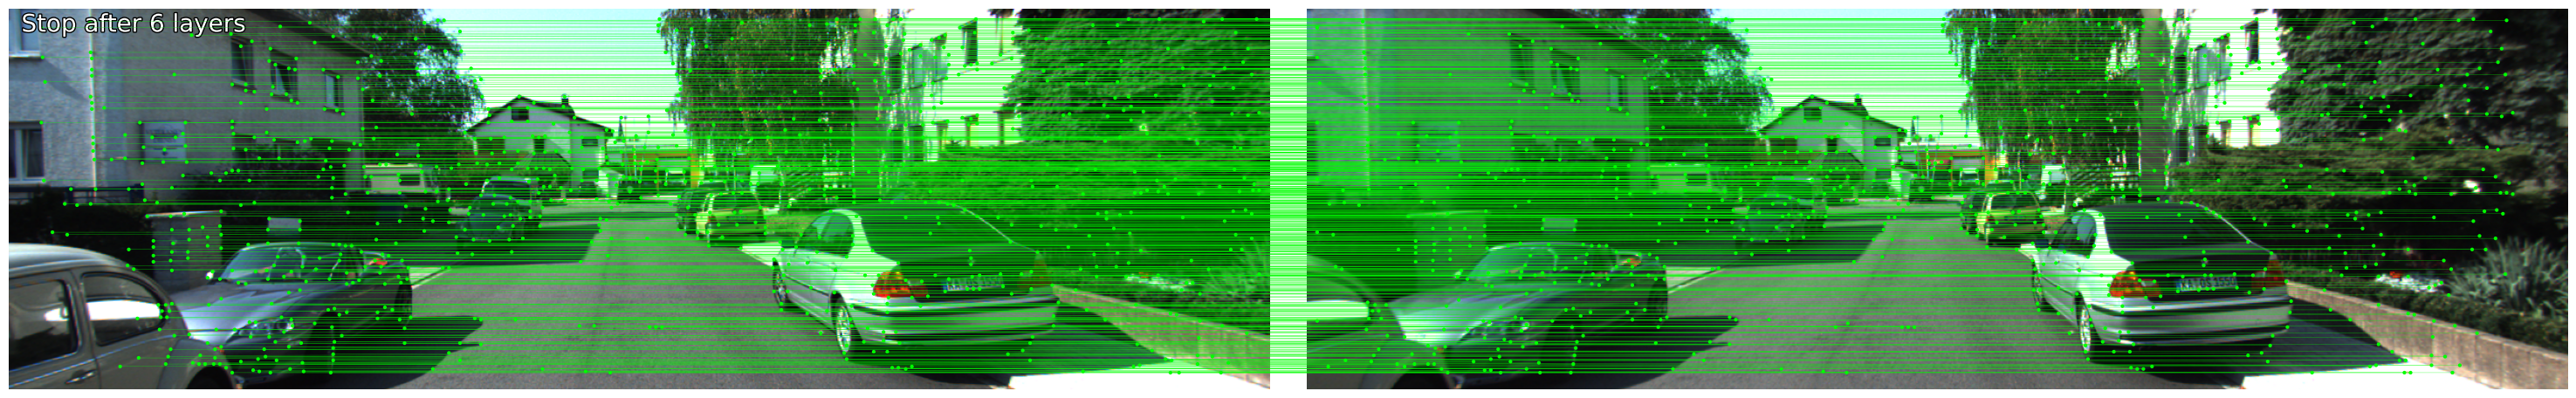

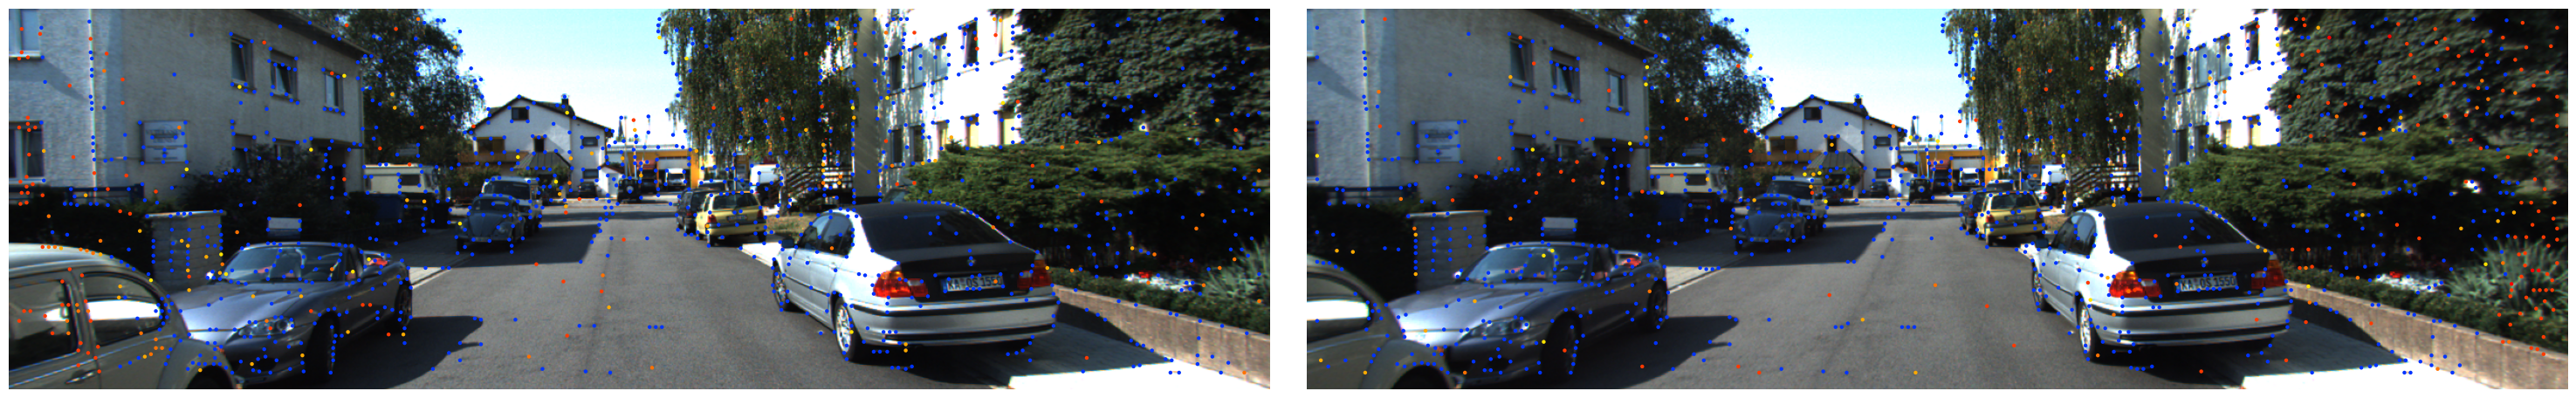

In [3]:

# we will use SuperPoint as the feature extractor
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features='superpoint').eval().to(device)


# read images from Kitti
image0, image1 = data.get_rgb(10)

# we have to convert the25 images into the proper format for pytorch
image0 = torchvision.transforms.functional.pil_to_tensor(image0).type(torch.FloatTensor)/255
image1 = torchvision.transforms.functional.pil_to_tensor(image1).type(torch.FloatTensor)/255

# extract features and match them
feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

kpts0, kpts1, matches = feats0['keypoints'], feats1['keypoints'], matches01['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

# visualise the matches
axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)